# 4. Statistical tests for 16S rRNA sequences

in this notebook, we will explore statistical analyses for the 16S rRNA sequences. The R scripts for this notebook are NMDS.R and Correlation.R

## Loading packages and creating useful files

The first step is to set the directory where the sequences were downloaded as working directory:

In [ ]:
setwd(paste0("[your path]/data/processed/16S_rRNA_seqs")) 

Now we will load the packages we are going to use:

In [161]:
#load libraries
library(vegan)
library(tidyr)
library(dplyr)
library(ggplot2)
library(ggpubr)
install.packages("Hmisc")
library(Hmisc)
install.packages("PerformanceAnalytics", dependencies = TRUE)
library(PerformanceAnalytics)

## Betadisperser and permutational ANOVA

One way we can integrate this info is with a permutational ANOVA test to see if any of the available information correlates with overall community structure (based on our ASVs, not taxonomy). 

In [91]:
#First, we need to build a distance matrix again with the normalized ASV counts
counts_tab<- read.csv("ASVs-counts_norm.tsv",header=T, row.names=1,check.names=F, sep="\t")

In [96]:
#We will import the table with sample information
sample_info_tab_1<- read.csv("sample_info_tab_1.tsv",header=T, row.names=1,check.names=F, sep="\t")

In [92]:
# The dist() program works on rows, so first we will transpose the 
# table with the t() function
euc_dist <- dist(t(counts_tab))

# hclust() is the function we use to cluster our distance matrix
euc_clust <- hclust(euc_dist, method="ward.D2")

Here we are going to test if there is a statistically significant difference between the cores or the depth bins.

In [97]:
#Calculate significance difference between intragroup variants
anova(betadisper(euc_dist, sample_info_tab_1$core))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,3081.937,1027.31232,10.59378,5.706765e-06
Residuals,83,8048.774,96.97318,NA,NA


Checking by core, we get a significant result (5.7 e-6) from the betadisper test. This tells us that there is a difference between group dispersions, which means that we can’t trust the results of an adonis (permutational anova) test on this, because the assumption of homogenous within-group dispersions is not met.

In [98]:
#Let’s check based on Depth bin:
anova(betadisper(euc_dist, sample_info_tab_1$Depth_bin))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,3,1065.985,355.3284,2.375073,0.07593929
Residuals,83,12417.411,149.6074,NA,NA


This test barely passes 0.05 so we will also omit further analyses.

## Non-metric Multidimensional Scaling (NMDS)

Although in notebook 3 we performed one NMDS, here, we want to correlate the species with the environmental variables. We will start by loading the tables of general and taxonomy level-specific ASV normalized counts. 

In [269]:
#Must use relative abundances or normalized counts, not raw counts
counts_tab<- read.csv("ASVs-counts_norm.tsv",header=T, row.names=1,check.names=F, sep="\t")
counts_tab_phylum<- read.table("SR2113_phylum.tsv",header=T, row.names=1,check.names=F, sep="\t")
counts_tab_order<- read.table("SR2113_order.tsv",header=T, row.names=1,check.names=F, sep="\t")
counts_tab_genus<- read.table("SR2113_genus.tsv",header=T, row.names=1,check.names=F, sep="\t")

Now we will make replacements in the count tables.

In [270]:
colnames(counts_tab) <-gsub("^[^_]*_", "", colnames(counts_tab))
colnames(counts_tab_phylum) <-gsub("^[^_]*_", "", colnames(counts_tab_phylum))
colnames(counts_tab_order) <-gsub("^[^_]*_", "", colnames(counts_tab_order))
colnames(counts_tab_genus) <-gsub("^[^_]*_", "", colnames(counts_tab_genus))

In [204]:
#Load the table with environmental variables
sample_info_tab <- read.table("/Users/dosorior/Library/CloudStorage/OneDrive-UniversityofSouthernCalifornia/git/seds_Cocos_Ridge/data/raw/SR2113_metadata_final.txt", sep = "\t", header = TRUE)
#sample_info_tab <- read.table("/[PATH]/git/seds_Cocos_Ridge/data/raw/SR2113_metadata_final.txt", sep = "\t", header = TRUE)

In [166]:
#Load the table with sample information
mod_sample_info_tab <- read.table("mod_sample_info_tab.tsv",header=T, row.names=1,check.names=F, sep="\t")

In [272]:
# Create relative abundance dataframes 
#Duplicate tables
counts_tab_phylum_1<-counts_tab_phylum
counts_tab_order_1<-counts_tab_order
counts_tab_genus_1<-counts_tab_genus
rownames (counts_tab_phylum_1) <- counts_tab_phylum$Phylum
counts_tab_phylum_1$Phylum<- NULL
relative_tab_phylum <- apply(counts_tab_phylum_1, 2, function(x) 100*(x/sum(x)))
rownames (counts_tab_order_1) <- counts_tab_order_1$Order
counts_tab_order_1$Order<- NULL
relative_tab_order <- apply(counts_tab_order_1, 2, function(x) 100*(x/sum(x)))
rownames (counts_tab_genus_1) <- counts_tab_genus_1$Genus
counts_tab_genus_1$Genus<- NULL
relative_tab_genus <- apply(counts_tab_genus_1, 2, function(x) 100*(x/sum(x)))


In [273]:
#Create a copy of the table for manipulation
phylum_tab_for_plot <- data.frame(counts_tab_phylum)
# now we'll transform the table into narrow, or long, format
phylum_tab_for_plot.g <- 
  phylum_tab_for_plot %>% 
  pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
#Add depth and core to table
phylum_tab_for_plot.g2 <- 
  phylum_tab_for_plot.g %>% left_join(mod_sample_info_tab)
#Replace dots by dashes in the samples names
phylum_tab_for_plot.g2$Sample <- gsub("^[^_]*_", "", phylum_tab_for_plot.g2$Sample)
#Get total Phylum ASVs for depth
df_sum <-
  phylum_tab_for_plot.g2 %>%
  group_by(Depth, Core) %>%
  summarise(Total = sum(Proportion))

Joining with `by = join_by(Sample)`
`summarise()` has grouped output by 'Depth'. You can override
using the `.groups` argument.


Below is an optional step to filter out depths with low ASV abundance.

In [274]:
#Filter out depths with less than 600 total ASVs
depths_to_keep <- subset(df_sum, as.numeric(Total) <= 900)
filtered_absolute_asvs <- phylum_tab_for_plot.g2
#filtered_absolute_asvs <- filter(phylum_tab_for_plot.g2,
#                                      phylum_tab_for_plot.g2$Depth %in% depths_to_keep$Depth)

#Drop unnecesary columns
filtered_absolute_asvs <- subset(filtered_absolute_asvs, select = -c(Core, Depth, core_colors, Depth_bin,depth_colors))

# Now we'll transform the table with AVSs only for depths with more than 600 total, to broad format
filtered_absolute_asvs_for_manip <- 
  filtered_absolute_asvs %>% 
  pivot_wider(names_from = Sample, values_from = Proportion) 


Warning message:
"Values from `Proportion` are not uniquely identified; output will
contain list-cols.
* Use `values_fn = list` to suppress this warning.
* Use `values_fn = {summary_fun}` to summarise duplicates.
* Use the following dplyr code to identify duplicates.
  {data} |>
  dplyr::summarise(n = dplyr::n(), .by = c(Phylum, Sample)) |>
  dplyr::filter(n > 1L)"


In [275]:
#Remove samples from the counts tab that have less than 600 AVSs
counts_tab_filtered<-counts_tab[,colnames(counts_tab) %in% colnames(filtered_absolute_asvs_for_manip)]


In [115]:
#create dataframe of ASV's and sample names in order needed for vegan package
data1 <- data.frame(t(counts_tab_filtered[])) #96 rows
datap <- data.frame(t(relative_tab_phylum[]))
datao <- data.frame(t(relative_tab_order[]))
datag <- data.frame(t(relative_tab_genus[]))
#data1 <- setNames(data.frame(t(counts_tab_filtered[,-1])), counts_tab_filtered[,1])
data1[data1 < 0] <- 0 
datap[datap < 0] <- 0 
datao[datao < 0] <- 0 
datag[datag < 0] <- 0 

In [116]:
#convert sample info / environmental variables into format needed for vegan
#samp1 <- sample_info_tab[,-1]
samp1 <- sample_info_tab
rownames(samp1) <- sample_info_tab[,1] #ID is in column N 1

In [117]:
#Drop values in the samp1 df that are not in the data1 df
samp2<-samp1[rownames(samp1) %in% rownames(data1) ,]
data2<-data1[rownames(data1) %in% rownames(samp2) ,]
datap2<-datap[rownames(datap) %in% rownames(samp2) ,]
datao2<-datao[rownames(datao) %in% rownames(samp2) ,]
datag2<-datag[rownames(datag) %in% rownames(samp2) ,]

In [118]:
#remove unneeded columns for ordination fitting
#THIS WILL BE UNIQUE TO YOUR DATA SET
#I am removing ALL columns except for the environmental data I want to test to see if it correlates with the NMDS plot
samp2 <- samp2 %>% select(-c(Core, Silica))
#change values to numeric value type
samp2$Calcium = as.numeric(samp2$Calcium)
samp2$Carbon_in_OM = as.numeric(samp2$Carbon_in_OM)
samp2$Iron = as.numeric(samp2$Iron)
samp2$Magnesium = as.numeric(samp2$Magnesium)
samp2$Manganese = as.numeric(samp2$Manganese)
samp2$Nitrate = as.numeric(samp2$Nitrate)
samp2$O_in_sulfate = as.numeric(samp2$O_in_sulfate)
samp2$S_in_Sulfate = as.numeric(samp2$S_in_Sulfate)
samp2$Strontium = as.numeric(samp2$Strontium)
samp2$Sulfate = as.numeric(samp2$Sulfate)
samp2$Sulfide = as.numeric(samp2$Sulfide)
samp2$Sulfite = as.numeric(samp2$Sulfite)
samp2$Thiosulfate = as.numeric(samp2$Thiosulfate)
samp2$TOC_percent = as.numeric(samp2$TOC_percent)

In [119]:
#create ordination
#CHECK THAT STRESS VALUES ARE GOOD
stations.mds <- metaMDS(data2, distance = "bray", autotransform = FALSE)

Run 0 stress 0.1864356 
Run 1 stress 0.1726671 
... New best solution
... Procrustes: rmse 0.1287125  max resid 0.3196771 
Run 2 stress 0.1888605 
Run 3 stress 0.16908 
... New best solution
... Procrustes: rmse 0.06083548  max resid 0.2071472 
Run 4 stress 0.1909537 
Run 5 stress 0.1736405 
Run 6 stress 0.169864 
Run 7 stress 0.1966816 
Run 8 stress 0.1739046 
Run 9 stress 0.1741271 
Run 10 stress 0.2064862 
Run 11 stress 0.1901296 
Run 12 stress 0.1783941 
Run 13 stress 0.211895 
Run 14 stress 0.1716703 
Run 15 stress 0.1722913 
Run 16 stress 0.1930326 
Run 17 stress 0.1900229 
Run 18 stress 0.1966515 
Run 19 stress 0.1831986 
Run 20 stress 0.1719645 
*** Best solution was not repeated -- monoMDS stopping criteria:
     4: no. of iterations >= maxit
    16: stress ratio > sratmax


In [ ]:
#create environmental vectors fit
stations.envfit <- envfit(stations.mds, samp2, permutations = 999, na.rm = TRUE)

In [121]:
#Extract sample and variable (species) scores
variableScores <- stations.mds$species
sampleScores <- stations.mds$points
stations.mds$stress

[1] 0.16908

In [ ]:
#create ordination for taxonomic categories
#CHECK THAT STRESS VALUES ARE GOOD
stations.mds.p <- metaMDS(datap2, distance = "bray", autotransform = FALSE)
stations.mds.o <- metaMDS(datao2, distance = "bray", autotransform = FALSE)
stations.mds.g <- metaMDS(datag2, distance = "bray", autotransform = FALSE)

In [ ]:
#create environmental vectors fit
stations.envfit.p <- envfit(stations.mds.p, samp2, permutations = 999, na.rm = TRUE)
stations.envfit.o <- envfit(stations.mds.o, samp2, permutations = 999, na.rm = TRUE)
stations.envfit.g <- envfit(stations.mds.g, samp2, permutations = 999, na.rm = TRUE)

In [65]:
#Extract sample and variable (species) scores
variableScores.p <- stations.mds.p$species
variableScores.o <- stations.mds.o$species
variableScores.g <- stations.mds.g$species

sampleScores.p <- stations.mds.p$points
sampleScores.o <- stations.mds.o$points
sampleScores.g <- stations.mds.g$points

stations.mds.p$stress
stations.mds.o$stress
stations.mds.g$stress

[1] 0.1467164

[1] 0.1615445

[1] 0.1563782

To plot the output from the mds using ggplot a new datasheet needs to be created which contains the x,y points for each site. We will do this by calling the scores of the MDS.

In [68]:
site.scrs <- as.data.frame(scores(stations.mds, display = "sites")) #save NMDS results into dataframe.
site.scrs <- cbind(site.scrs, Station = samp2$Station) #add grouping variable "station" to dataframe
site.scrs <- cbind(site.scrs, Calcium =samp2$Calcium)
site.scrs <- cbind(site.scrs, Carbon_in_OM = samp2$Carbon_in_OM)
site.scrs <- cbind(site.scrs, Iron = samp2$Iron)
site.scrs <- cbind(site.scrs, Magnesium = samp2$Magnesium)
site.scrs <- cbind(site.scrs, Manganese = samp2$Manganese)
site.scrs <- cbind(site.scrs, Nitrate = samp2$Nitrate)
site.scrs <- cbind(site.scrs, O_in_sulfate = samp2$O_in_sulfate)
site.scrs <- cbind(site.scrs, S_in_Sulfate =samp2$S_in_Sulfate)
site.scrs <- cbind(site.scrs, Strontium = samp2$Strontium)
site.scrs <- cbind(site.scrs, Sulfate = samp2$Sulfate)
site.scrs <- cbind(site.scrs, Sulfide = samp2$Sulfide)
site.scrs <- cbind(site.scrs, Sulfite = samp2$Sulfite)
site.scrs <- cbind(site.scrs, Thiosulfate = samp2$Thiosulfate)
site.scrs <- cbind(site.scrs, TOC_percent = samp2$TOC_percent)
site.scrs <- cbind(site.scrs, Real_depth_cm = samp2$Real_depth_cm)
site.scrs <- cbind(site.scrs, ID = samp2$ID)
site.scrs$ID <-gsub("^.*_", "", site.scrs$ID)

head(site.scrs)

,NMDS1,NMDS2,Station,Calcium,Carbon_in_OM,Iron,Magnesium,Manganese,Nitrate,O_in_sulfate,S_in_Sulfate,Strontium,Sulfate,Sulfide,Sulfite,Thiosulfate,TOC_percent,Real_depth_cm,ID
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GC06_111,-0.4235028,0.20954497,CR02,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.338317,5.446106,NA,15.5,15.5
GC06_81,-0.5691291,-0.05121015,CR02,10.12131,-21.23468,0.2608871,52.99774,13.72374,25.94460,8.190571,20.91684,89.53501,28.47510,10.89478,21.184303,2.421063,0.3671557,18.5,18.5
GC06_156,1.1574851,-1.24616854,CR02,10.15364,-20.65100,0.4082771,52.75572,18.27577,20.45232,NA,NA,89.33999,28.55341,18.43000,7.867032,10.287658,0.4725441,21.5,21.5
GC04_156,1.0961369,1.26406079,CR02,10.04440,-20.30705,0.3794844,53.49487,NA,12.60290,NA,NA,93.30689,28.45131,10.60509,6.655988,13.311976,0.6300283,39.5,39.5
GC06_166,-0.6883572,-0.12629947,CR02,10.26325,NA,2.6464512,54.03704,25.23259,0.00000,9.137104,21.58605,97.26183,28.55182,56.65833,69.609803,10.265132,NA,63.5,63.5
GC06_41,-0.6757693,0.26221235,CR02,10.19746,NA,8.5525344,54.21911,32.08625,4.06915,9.510000,NA,98.78602,28.43727,85.30690,95.000000,24.987118,NA,90.5,90.5


In [70]:
#For phyla
site.scrs.p <- as.data.frame(scores(stations.mds.p, display = "sites")) #save NMDS results into dataframe.
site.scrs.p <- cbind(site.scrs.p, Station = samp2$Station) #add grouping variable "station" to dataframe
site.scrs.p <- cbind(site.scrs.p, Calcium =samp2$Calcium)
site.scrs.p <- cbind(site.scrs.p, Carbon_in_OM = samp2$Carbon_in_OM)
site.scrs.p <- cbind(site.scrs.p, Iron = samp2$Iron)
site.scrs.p <- cbind(site.scrs.p, Magnesium = samp2$Magnesium)
site.scrs.p <- cbind(site.scrs.p, Manganese = samp2$Manganese)
site.scrs.p <- cbind(site.scrs.p, Nitrate = samp2$Nitrate)
site.scrs.p <- cbind(site.scrs.p, O_in_sulfate = samp2$O_in_sulfate)
site.scrs.p <- cbind(site.scrs.p, S_in_Sulfate =samp2$S_in_Sulfate)
site.scrs.p <- cbind(site.scrs.p, Strontium = samp2$Strontium)
site.scrs.p <- cbind(site.scrs.p, Sulfate = samp2$Sulfate)
site.scrs.p <- cbind(site.scrs.p, Sulfide = samp2$Sulfide)
site.scrs.p <- cbind(site.scrs.p, Sulfite = samp2$Sulfite)
site.scrs.p <- cbind(site.scrs.p, Thiosulfate = samp2$Thiosulfate)
site.scrs.p <- cbind(site.scrs.p, TOC_percent = samp2$TOC_percent)
site.scrs.p <- cbind(site.scrs.p, Real_depth_cm = samp2$Real_depth_cm)
site.scrs.p <- cbind(site.scrs.p, ID = samp2$ID)
site.scrs.p$ID <-gsub("^.*_", "", site.scrs.p$ID)

head(site.scrs.p)

,NMDS1,NMDS2,Station,Calcium,Carbon_in_OM,Iron,Magnesium,Manganese,Nitrate,O_in_sulfate,S_in_Sulfate,Strontium,Sulfate,Sulfide,Sulfite,Thiosulfate,TOC_percent,Real_depth_cm,ID
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GC06_111,-0.47414012,0.15627095,CR02,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.338317,5.446106,NA,15.5,15.5
GC06_81,0.01229137,-0.02930406,CR02,10.12131,-21.23468,0.2608871,52.99774,13.72374,25.94460,8.190571,20.91684,89.53501,28.47510,10.89478,21.184303,2.421063,0.3671557,18.5,18.5
GC06_156,1.29861630,0.57847089,CR02,10.15364,-20.65100,0.4082771,52.75572,18.27577,20.45232,NA,NA,89.33999,28.55341,18.43000,7.867032,10.287658,0.4725441,21.5,21.5
GC04_156,1.00278543,0.20049249,CR02,10.04440,-20.30705,0.3794844,53.49487,NA,12.60290,NA,NA,93.30689,28.45131,10.60509,6.655988,13.311976,0.6300283,39.5,39.5
GC06_166,-0.20601541,0.66738231,CR02,10.26325,NA,2.6464512,54.03704,25.23259,0.00000,9.137104,21.58605,97.26183,28.55182,56.65833,69.609803,10.265132,NA,63.5,63.5
GC06_41,0.07603890,0.55055088,CR02,10.19746,NA,8.5525344,54.21911,32.08625,4.06915,9.510000,NA,98.78602,28.43727,85.30690,95.000000,24.987118,NA,90.5,90.5


In [71]:
#For order
site.scrs.o <- as.data.frame(scores(stations.mds.o, display = "sites")) #save NMDS results into dataframe.
site.scrs.o <- cbind(site.scrs.o, Station = samp2$Station) #add grouping variable "station" to dataframe
site.scrs.o <- cbind(site.scrs.o, Calcium =samp2$Calcium)
site.scrs.o <- cbind(site.scrs.o, Carbon_in_OM = samp2$Carbon_in_OM)
site.scrs.o <- cbind(site.scrs.o, Iron = samp2$Iron)
site.scrs.o <- cbind(site.scrs.o, Magnesium = samp2$Magnesium)
site.scrs.o <- cbind(site.scrs.o, Manganese = samp2$Manganese)
site.scrs.o <- cbind(site.scrs.o, Nitrate = samp2$Nitrate)
site.scrs.o <- cbind(site.scrs.o, O_in_sulfate = samp2$O_in_sulfate)
site.scrs.o <- cbind(site.scrs.o, S_in_Sulfate =samp2$S_in_Sulfate)
site.scrs.o <- cbind(site.scrs.o, Strontium = samp2$Strontium)
site.scrs.o <- cbind(site.scrs.o, Sulfate = samp2$Sulfate)
site.scrs.o <- cbind(site.scrs.o, Sulfide = samp2$Sulfide)
site.scrs.o <- cbind(site.scrs.o, Sulfite = samp2$Sulfite)
site.scrs.o <- cbind(site.scrs.o, Thiosulfate = samp2$Thiosulfate)
site.scrs.o <- cbind(site.scrs.o, TOC_percent = samp2$TOC_percent)
site.scrs.o <- cbind(site.scrs.o, Real_depth_cm = samp2$Real_depth_cm)
site.scrs.o <- cbind(site.scrs.o, ID = samp2$ID)
site.scrs.o$ID <-gsub("^.*_", "", site.scrs.o$ID)

head(site.scrs.o)

,NMDS1,NMDS2,Station,Calcium,Carbon_in_OM,Iron,Magnesium,Manganese,Nitrate,O_in_sulfate,S_in_Sulfate,Strontium,Sulfate,Sulfide,Sulfite,Thiosulfate,TOC_percent,Real_depth_cm,ID
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GC06_111,-0.03011574,-0.05549517,CR02,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.338317,5.446106,NA,15.5,15.5
GC06_81,-0.59264264,-0.24279478,CR02,10.12131,-21.23468,0.2608871,52.99774,13.72374,25.94460,8.190571,20.91684,89.53501,28.47510,10.89478,21.184303,2.421063,0.3671557,18.5,18.5
GC06_156,0.30706716,1.80695041,CR02,10.15364,-20.65100,0.4082771,52.75572,18.27577,20.45232,NA,NA,89.33999,28.55341,18.43000,7.867032,10.287658,0.4725441,21.5,21.5
GC04_156,1.41072825,0.87682371,CR02,10.04440,-20.30705,0.3794844,53.49487,NA,12.60290,NA,NA,93.30689,28.45131,10.60509,6.655988,13.311976,0.6300283,39.5,39.5
GC06_166,-0.52215087,0.57291890,CR02,10.26325,NA,2.6464512,54.03704,25.23259,0.00000,9.137104,21.58605,97.26183,28.55182,56.65833,69.609803,10.265132,NA,63.5,63.5
GC06_41,-0.66328314,0.81949252,CR02,10.19746,NA,8.5525344,54.21911,32.08625,4.06915,9.510000,NA,98.78602,28.43727,85.30690,95.000000,24.987118,NA,90.5,90.5


In [72]:
#For genus
site.scrs.g <- as.data.frame(scores(stations.mds.g, display = "sites")) #save NMDS results into dataframe.
site.scrs.g <- cbind(site.scrs.g, Station = samp2$Station) #add grouping variable "station" to dataframe
site.scrs.g <- cbind(site.scrs.g, Calcium =samp2$Calcium)
site.scrs.g <- cbind(site.scrs.g, Carbon_in_OM = samp2$Carbon_in_OM)
site.scrs.g <- cbind(site.scrs.g, Iron = samp2$Iron)
site.scrs.g <- cbind(site.scrs.g, Magnesium = samp2$Magnesium)
site.scrs.g <- cbind(site.scrs.g, Manganese = samp2$Manganese)
site.scrs.g <- cbind(site.scrs.g, Nitrate = samp2$Nitrate)
site.scrs.g <- cbind(site.scrs.g, O_in_sulfate = samp2$O_in_sulfate)
site.scrs.g <- cbind(site.scrs.g, S_in_Sulfate =samp2$S_in_Sulfate)
site.scrs.g <- cbind(site.scrs.g, Strontium = samp2$Strontium)
site.scrs.g <- cbind(site.scrs.g, Sulfate = samp2$Sulfate)
site.scrs.g <- cbind(site.scrs.g, Sulfide = samp2$Sulfide)
site.scrs.g <- cbind(site.scrs.g, Sulfite = samp2$Sulfite)
site.scrs.g <- cbind(site.scrs.g, Thiosulfate = samp2$Thiosulfate)
site.scrs.g <- cbind(site.scrs.g, TOC_percent = samp2$TOC_percent)
site.scrs.g <- cbind(site.scrs.g, Real_depth_cm = samp2$Real_depth_cm)
site.scrs.g <- cbind(site.scrs.g, ID = samp2$ID)
site.scrs.g$ID <-gsub("^.*_", "", site.scrs.g$ID)

head(site.scrs.g)

,NMDS1,NMDS2,Station,Calcium,Carbon_in_OM,Iron,Magnesium,Manganese,Nitrate,O_in_sulfate,S_in_Sulfate,Strontium,Sulfate,Sulfide,Sulfite,Thiosulfate,TOC_percent,Real_depth_cm,ID
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
GC06_111,-0.17920744,0.05893161,CR02,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.338317,5.446106,NA,15.5,15.5
GC06_81,-0.61282568,-0.14400867,CR02,10.12131,-21.23468,0.2608871,52.99774,13.72374,25.94460,8.190571,20.91684,89.53501,28.47510,10.89478,21.184303,2.421063,0.3671557,18.5,18.5
GC06_156,1.42170514,-1.35933984,CR02,10.15364,-20.65100,0.4082771,52.75572,18.27577,20.45232,NA,NA,89.33999,28.55341,18.43000,7.867032,10.287658,0.4725441,21.5,21.5
GC04_156,1.00318499,1.57794501,CR02,10.04440,-20.30705,0.3794844,53.49487,NA,12.60290,NA,NA,93.30689,28.45131,10.60509,6.655988,13.311976,0.6300283,39.5,39.5
GC06_166,0.05451055,-0.66394521,CR02,10.26325,NA,2.6464512,54.03704,25.23259,0.00000,9.137104,21.58605,97.26183,28.55182,56.65833,69.609803,10.265132,NA,63.5,63.5
GC06_41,0.01906494,-0.99480332,CR02,10.19746,NA,8.5525344,54.21911,32.08625,4.06915,9.510000,NA,98.78602,28.43727,85.30690,95.000000,24.987118,NA,90.5,90.5


To show environmental extrinsic variables another datasheet needs to be created.

In [74]:
# To extracts relevant scores from envifit
env.scores.stations <- as.data.frame(scores(stations.envfit, display = "vectors")) 
# Giving the scores names
env.scores.stations <- cbind(env.scores.stations, env.variables = rownames(env.scores.stations)) 
# Adding p-values to dataframe
env.scores.stations <- cbind(env.scores.stations, pval = stations.envfit$vectors$pvals) 
#Subset data to show variables significant at 0.05. We have commented in this case because none of them are significant.
#sig.env.scrs <- subset(env.scores.stations, pval<=0.05) 
#We will take a look at the table to see the p values associated with each environmental data. 
include_list <- c("Carbon_in_OM", "Sulfide","Sulfate","Nitrate","Manganese","O_in_Sulfate")
sig.env.scrs <-subset(env.scores.stations, rownames(env.scores.stations) %in% include_list)
env.scores.stations
write.table(env.scores.stations,file="MDS_env_vars.txt")

,NMDS1,NMDS2,env.variables,pval
,<dbl>,<dbl>,<chr>,<dbl>
Real_depth_cm,0.025902997,0.49370248,Real_depth_cm,0.569
Calcium,0.072488096,-0.44840186,Calcium,0.650
Carbon_in_OM,0.005774673,-0.56801608,Carbon_in_OM,0.424
Iron,-0.001388509,0.40282569,Iron,0.677
Magnesium,-0.054960012,-0.55976426,Magnesium,0.439
Manganese,-0.256506027,0.41685529,Manganese,0.486
Nitrate,-0.343028880,0.12831057,Nitrate,0.700
O_in_sulfate,0.016270533,0.31619954,O_in_sulfate,0.862
S_in_Sulfate,0.038992633,0.34642856,S_in_Sulfate,0.745


In [75]:
#For Phylum
env.scores.stations.p <- as.data.frame(scores(stations.envfit.p, display = "vectors")) #extracts relevant scores from envifit
env.scores.stations.p <- cbind(env.scores.stations.p, env.variables = rownames(env.scores.stations.p)) #and then gives them their names
env.scores.stations.p <- cbind(env.scores.stations.p, pval = stations.envfit.p$vectors$pvals) # add pvalues to dataframe
#sig.env.scrs <- subset(env.scores.stations, pval<=0.05) #subset data to show variables significant at 0.05
#you can look at the table to see the p values associated with each environmental data. The significant ones are saved separated in sig.env.scrs and are used below in the next code chunk.
include_list <- c("Carbon_in_OM", "Sulfide","Sulfate","Nitrate","Manganese","O_in_Sulfate")
sig.env.scrs.p <-subset(env.scores.stations.p, rownames(env.scores.stations.p) %in% include_list)
env.scores.stations.p
write.table(env.scores.stations.p,file="MDS_env_vars_p.txt")

,NMDS1,NMDS2,env.variables,pval
,<dbl>,<dbl>,<chr>,<dbl>
Real_depth_cm,-0.29417181,0.53473802,Real_depth_cm,0.358
Calcium,0.37135213,-0.41184115,Calcium,0.509
Carbon_in_OM,0.44331775,-0.14711178,Carbon_in_OM,0.645
Iron,-0.12956978,0.49624010,Iron,0.549
Magnesium,0.17920165,-0.52042887,Magnesium,0.449
Manganese,-0.23304396,-0.05592461,Manganese,0.876
Nitrate,-0.06655136,0.02473881,Nitrate,0.993
O_in_sulfate,-0.27529533,0.55103747,O_in_sulfate,0.343
S_in_Sulfate,-0.19450974,0.53269419,S_in_Sulfate,0.425


In [76]:
#For Order
env.scores.stations.o <- as.data.frame(scores(stations.envfit.o, display = "vectors")) #extracts relevant scores from envifit
env.scores.stations.o <- cbind(env.scores.stations.o, env.variables = rownames(env.scores.stations.o)) #and then gives them their names
env.scores.stations.o <- cbind(env.scores.stations.o, pval = stations.envfit.o$vectors$pvals) # add pvalues to dataframe
#sig.env.scrs <- subset(env.scores.stations, pval<=0.05) #subset data to show variables significant at 0.05
#you can look at the table to see the p values associated with each environmental data. The significant ones are saved separated in sig.env.scrs and are used below in the next code chunk.
include_list <- c("Carbon_in_OM", "Sulfide","Sulfate","Nitrate","Manganese","O_in_Sulfate")
sig.env.scrs.o <-subset(env.scores.stations.o, rownames(env.scores.stations.o) %in% include_list)
env.scores.stations.o
write.table(env.scores.stations.o,file="MDS_env_vars_o.txt")

,NMDS1,NMDS2,env.variables,pval
,<dbl>,<dbl>,<chr>,<dbl>
Real_depth_cm,-0.15560217,0.30691020,Real_depth_cm,0.783
Calcium,0.20388464,-0.29372751,Calcium,0.784
Carbon_in_OM,0.19224249,-0.07713689,Carbon_in_OM,0.879
Iron,-0.08617844,0.38128512,Iron,0.689
Magnesium,0.09341423,-0.24112991,Magnesium,0.870
Manganese,-0.21685399,-0.25506512,Manganese,0.733
Nitrate,-0.14904806,-0.04863253,Nitrate,0.950
O_in_sulfate,-0.16979889,0.39809657,O_in_sulfate,0.636
S_in_Sulfate,-0.13474252,0.32969448,S_in_Sulfate,0.670


In [77]:
#For Genus
env.scores.stations.g <- as.data.frame(scores(stations.envfit.g, display = "vectors")) #extracts relevant scores from envifit
env.scores.stations.g <- cbind(env.scores.stations.g, env.variables = rownames(env.scores.stations.g)) #and then gives them their names
env.scores.stations.g <- cbind(env.scores.stations.g, pval = stations.envfit.g$vectors$pvals) # add pvalues to dataframe
#sig.env.scrs <- subset(env.scores.stations, pval<=0.05) #subset data to show variables significant at 0.05
#you can look at the table to see the p values associated with each environmental data. The significant ones are saved separated in sig.env.scrs and are used below in the next code chunk.
include_list <- c("Carbon_in_OM", "Sulfide","Sulfate","Nitrate","Manganese","O_in_Sulfate")
sig.env.scrs.g <-subset(env.scores.stations.g, rownames(env.scores.stations.g) %in% include_list)
env.scores.stations.g
write.table(env.scores.stations.g,file="MDS_env_vars_g.txt")

,NMDS1,NMDS2,env.variables,pval
,<dbl>,<dbl>,<chr>,<dbl>
Real_depth_cm,0.14358471,-0.28119525,Real_depth_cm,0.838
Calcium,-0.09388755,0.28849035,Calcium,0.877
Carbon_in_OM,0.04394461,0.17175536,Carbon_in_OM,0.934
Iron,0.27146180,-0.30408178,Iron,0.681
Magnesium,-0.12691507,0.19280321,Magnesium,0.900
Manganese,-0.33404511,0.05834352,Manganese,0.658
Nitrate,-0.15536406,-0.01504596,Nitrate,0.932
O_in_sulfate,0.21460526,-0.35669835,O_in_sulfate,0.696
S_in_Sulfate,0.16927808,-0.27470368,S_in_Sulfate,0.736


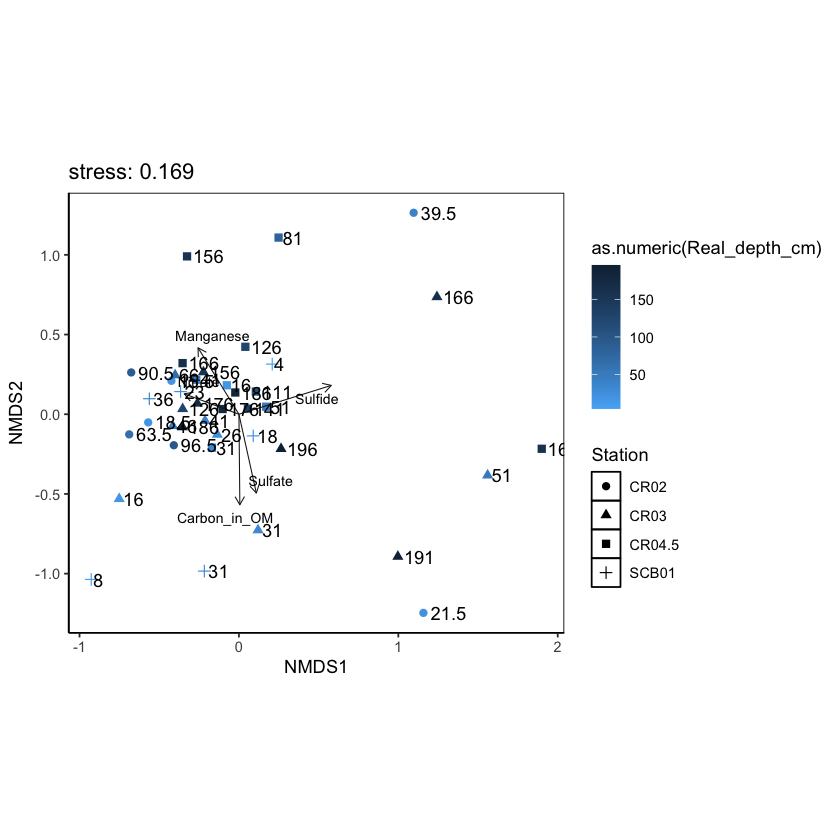

In [84]:
#MDS plot for samples by core
only_samples <- site.scrs

#Declare plot for MDS of samples with arrows and environmental variables
nmds.plot.stations_only_samples <- ggplot(only_samples, aes(x=NMDS1, y=NMDS2))+ #sets up the plot
  geom_point(aes(NMDS1,NMDS2, shape = Station,color = as.numeric(Real_depth_cm)),size = 2)+ 
  coord_fixed()+
  #scale_color_viridis_d() +
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  theme_classic()+ 
  theme(panel.background = element_rect(fill = NA, colour = "black", linetype = "solid"))+
  #=textNudge <- 1.2
  #text(variableScores[, 1]*textNudge, variableScores[, 2]*textNudge, rownames(variableScores), #cex=0.7)
  geom_segment(data = sig.env.scrs, aes(x = 0, xend=NMDS1, y=0, yend=NMDS2), arrow = arrow(length = unit(0.2, "cm")), colour = "grey10", lwd=0.3) +
  ggrepel::geom_text_repel(data = sig.env.scrs, aes(x=NMDS1, y=NMDS2, label = env.variables), cex = 3, direction = "both", segment.size = 1)+ #add labels for env variables
  ggtitle(paste0('stress: ', round(stations.mds$stress,3)))+
  geom_text(aes(label = ID), hjust = -0.2) #add labels to points

# labs(colour = "locale", shape = "station")+ # add legend labels
#theme(legend.position = "right", legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.text = element_text(size = 10)) # add legend at right of plot
#scale_shape_manual(values=c(15, 16, 17, 8))

#Display plot with arrows and environmental variables
nmds.plot.stations_only_samples 


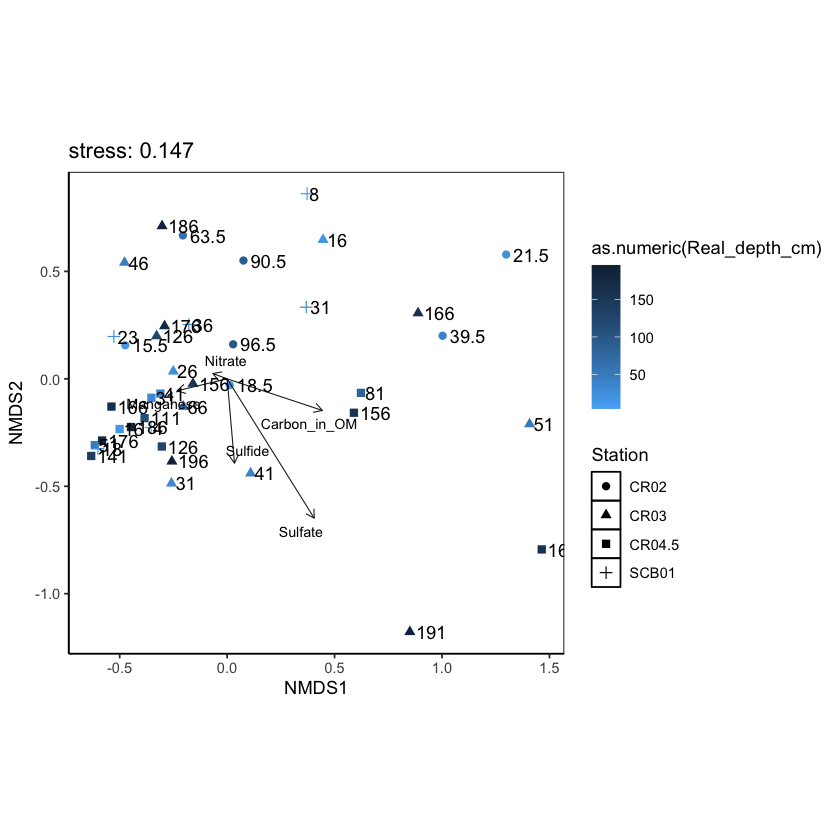

In [86]:
#Plot for Phylum
only_samples.p <- site.scrs.p
#filter(locale != "neg")

#Declare plot for MDS of samples with arrows and environmental variables
nmds.plot.stations_only_samples.p <- ggplot(only_samples.p, aes(x=NMDS1, y=NMDS2))+ #sets up the plot
  geom_point(aes(NMDS1,NMDS2, shape = Station,color = as.numeric(Real_depth_cm)),size = 2)+ 
  coord_fixed()+
  #scale_color_viridis_d() +
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  theme_classic()+ 
  theme(panel.background = element_rect(fill = NA, colour = "black", linetype = "solid"))+
  #=textNudge <- 1.2
  #text(variableScores[, 1]*textNudge, variableScores[, 2]*textNudge, rownames(variableScores), #cex=0.7)
  geom_segment(data = sig.env.scrs.p, aes(x = 0, xend=NMDS1, y=0, yend=NMDS2), arrow = arrow(length = unit(0.2, "cm")), colour = "grey10", lwd=0.3) +
  ggrepel::geom_text_repel(data = sig.env.scrs.p, aes(x=NMDS1, y=NMDS2, label = env.variables), cex = 3, direction = "both", segment.size = 1)+ #add labels for env variables
  ggtitle(paste0('stress: ', round(stations.mds.p$stress,3)))+
  geom_text(aes(label = ID), hjust = -0.2) #add labels to points

# labs(colour = "locale", shape = "station")+ # add legend labels 
#theme(legend.position = "right", legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.text = element_text(size = 10)) # add legend at right of plot
#scale_shape_manual(values=c(15, 16, 17, 8))

#Display plot with arrows and environmental variables
nmds.plot.stations_only_samples.p 


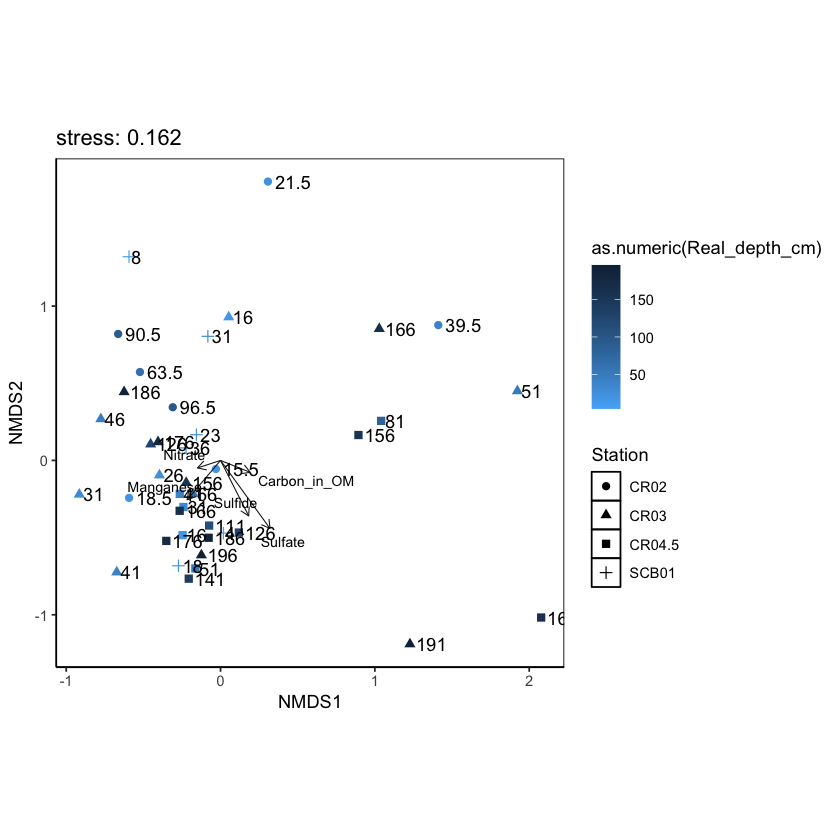

In [88]:
#Plot for Order
only_samples.o <- site.scrs.o
#filter(locale != "neg")

#Declare plot for MDS of samples with arrows and environmental variables
nmds.plot.stations_only_samples.o <- ggplot(only_samples.o, aes(x=NMDS1, y=NMDS2))+ #sets up the plot
  geom_point(aes(NMDS1,NMDS2, shape = Station,color = as.numeric(Real_depth_cm)),size = 2)+ 
  coord_fixed()+
  #scale_color_viridis_d() +
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  theme_classic()+ 
  theme(panel.background = element_rect(fill = NA, colour = "black", linetype = "solid"))+
  #=textNudge <- 1.2
  #text(variableScores[, 1]*textNudge, variableScores[, 2]*textNudge, rownames(variableScores), #cex=0.7)
  geom_segment(data = sig.env.scrs.o, aes(x = 0, xend=NMDS1, y=0, yend=NMDS2), arrow = arrow(length = unit(0.2, "cm")), colour = "grey10", lwd=0.3) +
  ggrepel::geom_text_repel(data = sig.env.scrs.o, aes(x=NMDS1, y=NMDS2, label = env.variables), cex = 3, direction = "both", segment.size = 1)+ #add labels for env variables
  ggtitle(paste0('stress: ', round(stations.mds.o$stress,3)))+
  geom_text(aes(label = ID), hjust = -0.2) #add labels to points

# labs(colour = "locale", shape = "station")+ # add legend labels for Management and Landuse
#theme(legend.position = "right", legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.text = element_text(size = 10)) # add legend at right of plot
#scale_shape_manual(values=c(15, 16, 17, 8))

#Display plot with arrows and environmental variables
nmds.plot.stations_only_samples.o 


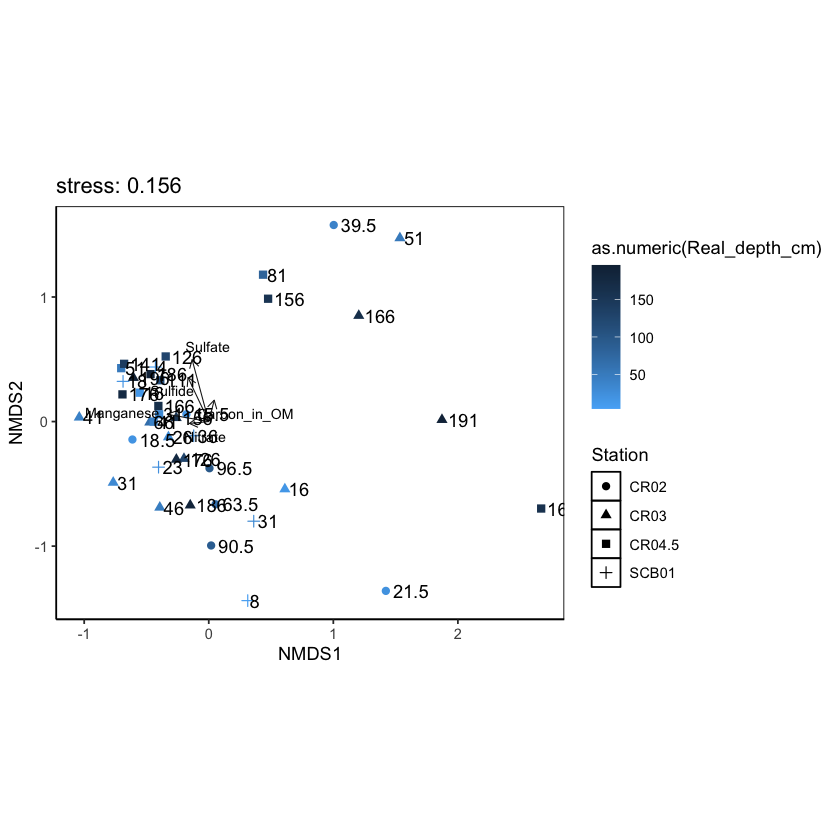

In [89]:
#Plot for Genus
only_samples.g <- site.scrs.g
#filter(locale != "neg")

#Declare plot for MDS of samples with arrows and environmental variables
nmds.plot.stations_only_samples.g <- ggplot(only_samples.g, aes(x=NMDS1, y=NMDS2))+ #sets up the plot
  geom_point(aes(NMDS1,NMDS2, shape = Station,color = as.numeric(Real_depth_cm)),size = 2)+ 
  coord_fixed()+
  #scale_color_viridis_d() +
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  theme_classic()+ 
  theme(panel.background = element_rect(fill = NA, colour = "black", linetype = "solid"))+
  #=textNudge <- 1.2
  #text(variableScores[, 1]*textNudge, variableScores[, 2]*textNudge, rownames(variableScores), #cex=0.7)
  geom_segment(data = sig.env.scrs.g, aes(x = 0, xend=NMDS1, y=0, yend=NMDS2), arrow = arrow(length = unit(0.2, "cm")), colour = "grey10", lwd=0.3) +
  ggrepel::geom_text_repel(data = sig.env.scrs.g, aes(x=NMDS1, y=NMDS2, label = env.variables), cex = 3, direction = "both", segment.size = 1)+ #add labels for env variables
  ggtitle(paste0('stress: ', round(stations.mds.g$stress,3)))+
  geom_text(aes(label = ID), hjust = -0.2) #add labels to points

# labs(colour = "locale", shape = "station")+ # add legend labels for Management and Landuse
#theme(legend.position = "right", legend.text = element_text(size = 12), legend.title = element_text(size = 12), axis.text = element_text(size = 10)) # add legend at right of plot
#scale_shape_manual(values=c(15, 16, 17, 8))

#Display plot with arrows and environmental variables
nmds.plot.stations_only_samples.g 

## Correlation analysis

In [192]:
#Create abundance table
abund_table <-t(filtered_absolute_asvs_for_manip)
abund_table <- abund_table[grepl("NA", rownames(abund_table))==F,]
#rownames(abund_table) <-gsub("^[^_]*_", "", rownames(abund_table))
#Set Phylum as row names
colnames(abund_table) <- lapply(abund_table[1, ], as.character)
abund_table <- abund_table[-1,] 

In [205]:
#Add an ID column to the metadata table
rownames(sample_info_tab) <- sample_info_tab$ID
head(sample_info_tab)

,ID,Station,Core,Real_depth_cm,Calcium,Carbon_in_OM,Iron,Magnesium,Manganese,Nitrate,O_in_sulfate,S_in_Sulfate,Silica,Strontium,Sulfate,Sulfide,Sulfite,Thiosulfate,TOC_percent,ASVs
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GC02_6.5,GC02_6.5,CR02,GC02,6.5,10.14967,-20.87602,0.4289842,52.81908,1.82020,37.03607,NA,21.00495,252.7,89.36649,28.42002,0.00000,14.524811,6.052004,0.3198826,4758
GC02_15.5,GC02_15.5,CR02,GC02,15.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,16.338317,5.446106,NA,210
GC02_18.5,GC02_18.5,CR02,GC02,18.5,10.12131,-21.23468,0.2608871,52.99774,13.72374,25.94460,8.190571,20.91684,359.9,89.53501,28.47510,10.89478,21.184303,2.421063,0.3671557,413
GC02_21.5,GC02_21.5,CR02,GC02,21.5,10.15364,-20.65100,0.4082771,52.75572,18.27577,20.45232,NA,NA,373.9,89.33999,28.55341,18.43000,7.867032,10.287658,0.4725441,282
GC02_24.5,GC02_24.5,CR02,GC02,24.5,10.12110,NA,0.4195835,52.60761,15.10592,19.50088,8.238678,21.22431,369.9,91.66034,28.60128,20.57402,21.179141,8.850000,NA,NA
GC02_27.5,GC02_27.5,CR02,GC02,27.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,23.62472,21.748300,10.874150,NA,NA


In [206]:
#Extract the corresponding meta_table for the samples in abund_table
sample_info_tab<-sample_info_tab[rownames(abund_table),]
sample_info_tab <- sample_info_tab[grepl("NA", rownames(sample_info_tab))==F,]

colnames(sample_info_tab)

[1] "ID"            "Station"       "Core"          "Real_depth_cm"
 [5] "Calcium"       "Carbon_in_OM"  "Iron"          "Magnesium"    
 [9] "Manganese"     "Nitrate"       "O_in_sulfate"  "S_in_Sulfate" 
[13] "Silica"        "Strontium"     "Sulfate"       "Sulfide"      
[17] "Sulfite"       "Thiosulfate"   "TOC_percent"   "ASVs"

In [207]:
# Use sel_env to specify the variables you want to use and sel_env_label to specify the labes for the panel
sel_env<-c("Real_depth_cm","Iron","Manganese","Nitrate","Sulfate","Sulfide","Sulfite","Thiosulfate", "Carbon_in_OM", "TOC_percent", "O_in_sulfate", "S_in_Sulfate")
sel_env_label <- list(
  'Real_depth_cm'="Depth (cm)",
  'Iron'="Iron",
  'Manganese'="Manganese",
  'Nitrate'="Nitrate",
  'Sulfate'="Sulfate",
  'Sulfide'='Sulfide',
  'Sulfite'='Sulfite',
  "Thiosulfate"="Thiosulfate",
  #"ASVs"="ASVs",
  "Carbon_in_OM"="d13C OM",
  "TOC_percent" = "% TOC",
  'O_in_sulfate'="d18O Sulfate",
  'S_in_Sulfate'="d34S Sulfate"
)

sel_env_label<-t(as.data.frame(sel_env_label))
sel_env_label<-as.data.frame(sel_env_label)
colnames(sel_env_label)<-c("Trans")
sel_env_label$Trans<-as.character(sel_env_label$Trans)


In [339]:
#Now get a filtered table based on sel_env
meta_table_filtered<-sample_info_tab[,sel_env]
meta_table_filtered <- meta_table_filtered[grepl("^NA", rownames(meta_table_filtered))==F,]
abund_table_filtered<-abund_table[rownames(meta_table_filtered),]

#Convert abundance table to numeric
abund_table_filtered <- apply(abund_table_filtered, 2, as.numeric)
rownames(abund_table_filtered) <- rownames(meta_table_filtered)

In [340]:
#Add core and depth to abundance table

mod_sample_info_tab$Sample <-gsub("^[^_]*_", "", mod_sample_info_tab$Sample)
abund_table_cd <- data.frame(abund_table_filtered) 
abund_table_cd$Sample <- rownames(abund_table_cd)
abund_table_cd_1 <- abund_table_cd %>% left_join(mod_sample_info_tab)

Joining with `by = join_by(Sample)`


In [341]:
#Apply normalisation (either use relative or log-relative transformation)
#x<-abund_table_filtered/rowSums(abund_table_filtered)
x<-log((abund_table_filtered+1)/(rowSums(abund_table_filtered)+dim(abund_table_filtered)[2]))
x<-x[,order(colSums(x),decreasing=TRUE)]

In [342]:
#Extract list of taxa
taxa_list<-colnames(x)

In [354]:
#remove "__Unknown__" and add it to others
taxa_list<-taxa_list[!grepl("Unknown",taxa_list)]
N<-length(taxa_list)
x<-data.frame(x[,colnames(x) %in% taxa_list])
y<-meta_table_filtered
rownames(y)

[1] "GC04_136"   "GC06_111"   "GC06_81"    "GC06_156"   "GC04_156"  
 [6] "GC06_166"   "GC06_171"   "GC06_146"   "GC06_71"    "GC06_121"  
[11] "GC06_41"    "GC02_63.5"  "GC02_90.5"  "GC04_206"   "GC04_191"  
[16] "GC06_186"   "GC06_176"   "MC01_23"    "MC01_18"    "MC01_12"   
[21] "MC01_8"     "MC01_2"     "GC06_101"   "MC01_4"     "GC06_51"   
[26] "GC06_91"    "GC06_21"    "GC02_114.5" "GC04_201"   "GC02_99.5" 
[31] "GC06_131"   "GC06_61"    "GC02_84.5"  "GC02_105.5" "GC02_126.5"
[36] "GC04_86"    "GC02_111.5" "GC02_45.5"  "GC02_57.5"  "GC02_72.5" 
[41] "GC06_31"    "GC02_81.5"  "GC02_18.5"  "GC02_51.5"  "GC06_181"  
[46] "GC02_6.5"   "GC02_39.5"  "GC04_186"   "GC04_166"   "GC04_196"  
[51] "GC06_16"    "GC02_21.5"  "GC06_161"   "GC04_146"   "GC04_71"   
[56] "GC06_141"   "GC04_106"   "GC04_96"    "GC06_126"   "GC04_26"   
[61] "GC02_15.5"  "MC01_27"    "GC02_60.5"  "GC02_93.5"  "GC04_176"  
[66] "GC04_16"    "GC02_117.5" "MC01_31"    "MC01_36"    "GC06_56"   
[71] "GC04_76"    "GC02_36.5"  "GC02_96.5"  "GC04_41"    "GC06_11"   
[76] "GC02_87.5"  "GC04_51"    "GC04_46"    "GC04_61"    "GC04_66"   
[81] "GC04_11"    "GC04_126"   "GC04_31"    "GC04_116"

In [344]:
#Get grouping information
grouping_info<-sample_info_tab$Station
grouping_info

[1] "CR03"   "CR04.5" "CR04.5" "CR04.5" "CR03"   "CR04.5" "CR04.5" "CR04.5"
 [9] "CR04.5" "CR04.5" "CR04.5" "CR02"   "CR02"   "CR03"   "CR03"   "CR04.5"
[17] "CR04.5" "SCB01"  "SCB01"  "SCB01"  "SCB01"  "SCB01"  "CR04.5" "SCB01" 
[25] "CR04.5" "CR04.5" "CR04.5" "CR02"   "CR03"   "CR02"   "CR04.5" "CR04.5"
[33] "CR02"   "CR02"   "CR02"   "CR03"   "CR02"   "CR02"   "CR02"   "CR02"  
[41] "CR04.5" "CR02"   "CR02"   "CR02"   "CR04.5" "CR02"   "CR02"   "CR03"  
[49] "CR03"   "CR03"   "CR04.5" "CR02"   "CR04.5" "CR03"   "CR03"   "CR04.5"
[57] "CR03"   "CR03"   "CR04.5" "CR03"   "CR02"   "SCB01"  "CR02"   "CR02"  
[65] "CR03"   "CR03"   "CR02"   "SCB01"  "SCB01"  "CR04.5" "CR03"   "CR02"  
[73] "CR02"   "CR03"   "CR04.5" "CR02"   "CR03"   "CR03"   "CR03"   "CR03"  
[81] "CR03"   "CR03"   "CR03"   "CR03"

In [345]:
#Merge taxa and env. variables dataframes
data_frame_merge <- merge(x, y,
                          by = 'row.names', all = TRUE)
#Creating core and Depth columns in the df 
x_1 <- abs(x)
x_1 <- data.frame(x_1,do.call(rbind,str_split(rownames(x_1),"_")))
# Changing column names
colnames(x_1)[colnames(x_1) == 'X1'] <- 'Core'
colnames(x_1)[colnames(x_1) == 'X2'] <- 'Depth'
x_1$Depth<-as.double(x_1$Depth)
#Add total ASVs
x_1 <- x_1 %>% left_join(df_sum)
colnames(x_1)[colnames(x_1) == 'Total'] <- 'Total_ASVs'

Joining with `by = join_by(Core, Depth)`


In [346]:
#Create category based on total ASVs
ASV_groups <- c()

for (entry in x_1 %>% pull(Total_ASVs)) {
  
  if (as.numeric(entry) %>% between(0,1000)) {
    
    ASV_groups <- c(ASV_groups, "below 1000")
    
  } else if (as.numeric(entry) %>% between(1001,4999)) {
    
    ASV_groups <- c(ASV_groups, "1000-5000")
    
  } else {
    
    ASV_groups <- c(ASV_groups, "above 5000")
    
  }
  
}
#Append it to table
x_1$ASV_groups <- ASV_groups

In [347]:
#Subset by core
x_1_mc01 <- subset(x_1, grepl('^MC01', rownames(x)))
x_1_gc02 <- subset(x_1, grepl('^GC02', rownames(x)))
x_1_gc04 <- subset(x_1, grepl('^GC04', rownames(x)))
x_1_gc06 <- subset(x_1, grepl('^GC06', rownames(x)))

In [348]:
#Order
x_1 <- x_1[order(x_1$Core,x_1$Depth ),]
head(x_1)

,Actinobacteriota,Chloroflexi,Firmicutes,Proteobacteria,unclassified_Bacteria,Planctomycetota,Caldatribacteriota,Crenarchaeota,Acidobacteriota,Aerophobota,...,MBNT15,Iainarchaeota,Euryarchaeota,WOR.1,Cloacimonadota,Unclassified,Core,Depth,Total_ASVs,ASV_groups
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<chr>
46,3.189395,2.579205,4.7524401,2.102961,5.308728,2.058714,1.833589,3.286103,3.153726,1.873242,...,9.069928,9.069928,9.069928,9.069928,9.069928,9.069928,GC02,6.5,8623,above 5000
61,2.345006,3.954444,0.6104048,4.359909,3.181254,3.443618,4.136765,5.746203,5.746203,4.647591,...,5.746203,5.746203,5.746203,5.746203,5.746203,5.746203,GC02,15.5,246,below 1000
43,1.841097,4.515245,1.4899544,2.527371,2.541164,5.719218,1.624874,5.719218,6.817831,2.274536,...,6.817831,6.817831,6.817831,6.817831,6.817831,6.817831,GC02,18.5,847,below 1000
52,1.328239,3.655517,1.1449015,2.764544,2.994118,3.292611,4.230881,4.030210,4.482195,2.817187,...,6.428105,6.428105,6.428105,6.428105,6.428105,6.428105,GC02,21.5,552,below 1000
72,2.253185,1.855883,7.9126672,4.357319,3.027343,2.973409,2.155871,2.388543,2.995122,2.257842,...,9.011279,9.011279,9.011279,9.011279,9.011279,9.011279,GC02,36.5,8128,above 5000
47,2.639057,5.411646,2.1158092,3.619887,3.465736,4.207673,1.356967,3.619887,6.510258,2.383124,...,6.510258,6.510258,6.510258,6.510258,6.510258,6.510258,GC02,39.5,605,below 1000


In [349]:
#Get absolute value and convert to matrix
x.matrix<-as.matrix(abs(x))
x_mc01.matrix<-as.matrix(abs(x_mc01))
x_gc02.matrix<-as.matrix(abs(x_gc02))
x_gc04.matrix<-as.matrix(abs(x_gc04))
x_gc06.matrix<-as.matrix(abs(x_gc06))

# Create distance matrices
x.dist<-vegdist(x.matrix, method='bray')
x_mc01.dist<-vegdist(x_mc01.matrix, method='bray')
x_gc02.dist<-vegdist(x_gc02.matrix, method='bray')
x_gc04.dist<-vegdist(x_gc04.matrix, method='bray')
x_gc06.dist<-vegdist(x_gc06.matrix, method='bray')

#Perform permANOVA to determine if there are differences in taxonomy (phylum) between cores
x.div<-adonis2(x.dist~Core, data=x_1, permutations = 999, method="bray")
x.div

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Core,3,0.03274172,0.04818225,1.349901,0.213
Residual,80,0.64679741,0.95181775,NA,NA
Total,83,0.67953913,1.00000000,NA,NA


There does not seem to be a significant difference (p<0.05) in taxonomy between cores.

In [224]:
#Define pairwise adonis function
pairwise.adonis <- function(x,factors, sim.function = 'vegdist', sim.method = 'bray', p.adjust.m ='bonferroni',reduce=NULL,perm=999)
{
  
  co <- combn(unique(as.character(factors)),2)
  pairs <- c()
  Df <- c()
  SumsOfSqs <- c()
  F.Model <- c()
  R2 <- c()
  p.value <- c()
  
  
  for(elem in 1:ncol(co)){
    if(inherits(x, 'dist')){
      x1=as.matrix(x)[factors %in% c(as.character(co[1,elem]),as.character(co[2,elem])),
                      factors %in% c(as.character(co[1,elem]),as.character(co[2,elem]))]
    }
    
    else  (
      if (sim.function == 'daisy'){
        x1 = daisy(x[factors %in% c(co[1,elem],co[2,elem]),],metric=sim.method)
      }
      else{x1 = vegdist(x[factors %in% c(co[1,elem],co[2,elem]),],method=sim.method)}
    )
    
    x2 = data.frame(Fac = factors[factors %in% c(co[1,elem],co[2,elem])])
    
    ad <- adonis2(x1 ~ Fac, data = x2,
                  permutations = perm);
    pairs <- c(pairs,paste(co[1,elem],'vs',co[2,elem]));
    Df <- c(Df,ad$Df[1])
    SumsOfSqs <- c(SumsOfSqs,ad$SumOfSqs[1])
    F.Model <- c(F.Model,ad$F[1]);
    R2 <- c(R2,ad$R2[1]);
    p.value <- c(p.value,ad$`Pr(>F)`[1])
  }
  p.adjusted <- p.adjust(p.value,method=p.adjust.m)
  
  sig = c(rep('',length(p.adjusted)))
  sig[p.adjusted <= 0.05] <-'.'
  sig[p.adjusted <= 0.01] <-'*'
  sig[p.adjusted <= 0.001] <-'**'
  sig[p.adjusted <= 0.0001] <-'***'
  pairw.res <- data.frame(pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig)
  
  if(!is.null(reduce)){
    pairw.res <- subset (pairw.res, grepl(reduce,pairs))
    pairw.res$p.adjusted <- p.adjust(pairw.res$p.value,method=p.adjust.m)
    
    sig = c(rep('',length(pairw.res$p.adjusted)))
    sig[pairw.res$p.adjusted <= 0.1] <-'.'
    sig[pairw.res$p.adjusted <= 0.05] <-'*'
    sig[pairw.res$p.adjusted <= 0.01] <-'**'
    sig[pairw.res$p.adjusted <= 0.001] <-'***'
    pairw.res <- data.frame(pairw.res[,1:7],sig)
  }
  class(pairw.res) <- c("pwadonis", "data.frame")
  return(pairw.res)
}

### Method summary
summary.pwadonis = function(object, ...) {
  cat("Result of pairwise.adonis:\n")
  cat("\n")
  print(object, ...)
  cat("\n")
  cat("Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1\n")
}

In [306]:
#Run pairwise permANOVA
b <- pairwise.adonis(x, x_1$ASV_groups, sim.method = "euclidean",
                     p.adjust.m = "bonferroni")
b


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
above 5000 vs below 1000,1,187.58785,1.3800062,0.025377089,0.172,0.516,
above 5000 vs 1000-5000,1,231.28832,1.8352738,0.038366537,0.085,0.255,
below 1000 vs 1000-5000,1,75.66823,0.6181246,0.009716171,0.735,1.000,


There does not seem to be a difference in taxonomic groups between samples with different numbers of ASVs, so there's no need to filter out samples with low number of ASVs.

#### Heatmap for correlation between taxonomic groups and environmental variables

In [350]:
# First, we will need to filter by core
mc01_phyla_df <- dplyr::filter(data_frame_merge, grepl('MC01', Row.names))
gc02_phyla_df <- dplyr::filter(data_frame_merge, grepl('GC02', Row.names))
gc04_phyla_df <- dplyr::filter(data_frame_merge, grepl('GC04', Row.names))
gc06_phyla_df <- dplyr::filter(data_frame_merge, grepl('GC06', Row.names))
head(gc02_phyla_df)

,Row.names,Actinobacteriota,Chloroflexi,Firmicutes,Proteobacteria,unclassified_Bacteria,Planctomycetota,Caldatribacteriota,Crenarchaeota,Acidobacteriota,...,Manganese,Nitrate,Sulfate,Sulfide,Sulfite,Thiosulfate,Carbon_in_OM,TOC_percent,O_in_sulfate,S_in_Sulfate
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GC02_105.5,-3.418795,-1.704214,-3.0427440,-5.167995,-3.213196,-1.433306,-2.027081,-2.464120,-4.111942,...,30.54123,4.468723,28.27563,14.840864,30.25540,65.445972,NA,NA,9.543664,21.91779
2,GC02_111.5,-1.721064,-4.765587,-1.6867397,-5.864199,-4.295583,-7.473637,-5.527727,-2.661453,-3.142904,...,31.52807,0.000000,28.31026,6.657225,49.97167,24.208089,-22.76862,NA,NA,NA
3,GC02_114.5,-4.428214,-1.914046,-5.0874592,-3.368669,-3.924308,-2.492204,-1.508271,-2.726605,-2.347336,...,NA,0.000000,28.27852,6.656289,47.19914,26.267540,-23.00682,0.6097311,9.780000,21.92580
4,GC02_117.5,-2.133248,-2.400244,-2.9871686,-3.955161,-3.392634,-2.156622,-7.846981,-3.241811,-3.102049,...,30.66463,2.119882,28.20872,5.250000,32.68367,27.841641,NA,NA,NA,22.32841
5,GC02_126.5,-2.272075,-1.868253,-6.6689903,-1.414625,-2.420495,-1.964880,-8.278428,-3.524838,-2.789491,...,32.88570,2.978746,28.20453,6.430000,19.97115,26.628207,-23.18862,0.7734036,9.860000,NA
6,GC02_15.5,-2.345006,-3.954444,-0.6104048,-4.359909,-3.181254,-3.443618,-4.136765,-5.746203,-5.746203,...,NA,NA,NA,NA,16.33832,5.446106,NA,NA,NA,NA


Warning message:
"Removed 2 rows containing missing values or values outside the
scale range (`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the
scale range (`geom_text()`)."


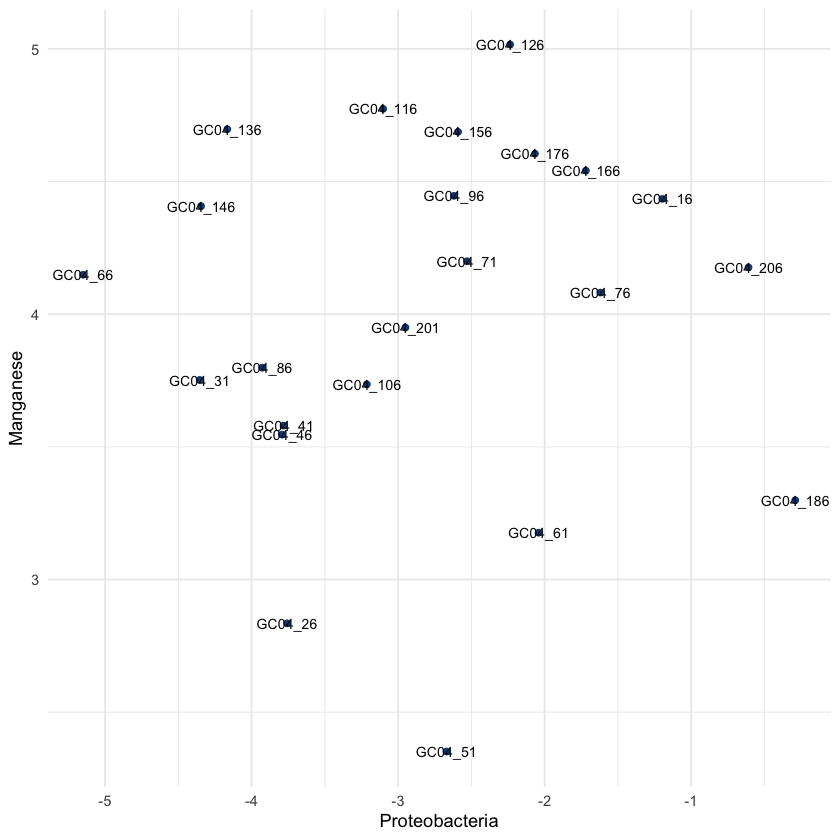

In [351]:
# Now, we will make a plot to see if there are any correlations
`%nin%` = Negate(`%in%`)
updated_proteo_gc02 <- subset(gc02_phyla_df, Row.names!= "GC02_6.5")
updated_proteo_gc04 <- subset(gc04_phyla_df, Row.names %nin% c("GC04_11", "GC04_6.5"))
#Make scatter plots to visualize correlations for GC 04
p <- ggplot(updated_proteo_gc04) +
  aes(x = Proteobacteria, y = Manganese) +
  geom_point(colour = "#0c4c8a") +
  geom_text(aes(label=Row.names), size=3) +
  theme_minimal()
print (p)


In [366]:
#Get grouping information
grouping_info<-sample_info_tab$Station
#Let us group on cores
groups<-grouping_info

#You can use kendall, spearman, or pearson below:
method<-"kendall"

In [367]:
#We will remove columns we will not use from y because they don't have enough data for all the cores
y_sub<- subset(y, select = -c(Carbon_in_OM,TOC_percent,O_in_sulfate,S_in_Sulfate))
#Now we will drop NA   
y_sub <- drop_na(y_sub)
head(y_sub)

,Real_depth_cm,Iron,Manganese,Nitrate,Sulfate,Sulfide,Sulfite,Thiosulfate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GC04_136,136,2.828545,4.697548,5.206727,28.18768,57.84169,26.02409,17.55113
GC06_111,111,8.077631,6.108953,1.767016,28.32262,94.80907,61.75185,10.28669
GC06_81,81,4.676111,4.886956,0.000000,28.56755,55.06617,65.35325,18.12273
GC06_156,156,5.545699,5.559959,1.720472,28.05195,88.35685,87.75167,31.81254
GC04_156,156,1.778456,4.687312,4.251938,28.17119,31.79492,60.50000,13.31911
GC06_166,166,2.399186,5.543990,3.513052,28.02792,30.25834,49.62529,37.52034


In [359]:
#Now calculate the correlation between individual Taxa and the environmental data
df<-NULL
for(i in colnames(x)){
  for(j in colnames(y_sub)){
    for(k in unique(groups)){
      a<-x[groups==k,i,drop=F]
      b<-y[groups==k,j,drop=F]
      tmp<-c(i,j,cor(a[complete.cases(b),],b[complete.cases(b),],use="everything",method=method),cor.test(a[complete.cases(b),],b[complete.cases(b),],method=method,exact=FALSE)$p.value,k)
      if(is.null(df)){
        df<-tmp  
      }
      else{
        df<-rbind(df,tmp)
      }    
    }
  }
}

In [360]:
df<-data.frame(row.names=NULL,df)
colnames(df)<-c("Taxa","Env","Correlation","Pvalue","Type")
df$Pvalue<-as.numeric(as.character(df$Pvalue))
df$AdjPvalue<-rep(0,dim(df)[1])
df$Correlation<-as.numeric(as.character(df$Correlation))


In [361]:
#You can adjust the p-values for multiple comparison using Benjamini & Hochberg (1995):
# 1 -> donot adjust
# 2 -> adjust Env + Type (column on the correlation plot)
# 3 -> adjust Taxa + Type (row on the correlation plot for each type)
# 4 -> adjust Taxa (row on the correlation plot)
# 5 -> adjust Env (panel on the correlation plot)
adjustment_label<-c("NoAdj","AdjEnvAndType","AdjTaxaAndType","AdjTaxa","AdjEnv")
adjustment<-5

In [362]:
if(adjustment==1){
  df$AdjPvalue<-df$Pvalue
} else if (adjustment==2){
  for(i in unique(df$Env)){
    for(j in unique(df$Type)){
      sel<-df$Env==i & df$Type==j
      df$AdjPvalue[sel]<-p.adjust(df$Pvalue[sel],method="BH")
    }
  }
} else if (adjustment==3){
  for(i in unique(df$Taxa)){
    for(j in unique(df$Type)){
      sel<-df$Taxa==i & df$Type==j
      df$AdjPvalue[sel]<-p.adjust(df$Pvalue[sel],method="BH")
    }
  }
} else if (adjustment==4){
  for(i in unique(df$Taxa)){
    sel<-df$Taxa==i
    df$AdjPvalue[sel]<-p.adjust(df$Pvalue[sel],method="BH")
  }
} else if (adjustment==5){
  for(i in unique(df$Env)){
    sel<-df$Env==i
    df$AdjPvalue[sel]<-p.adjust(df$Pvalue[sel],method="BH")
  }
}

In [363]:
#Now we generate the labels for significant values
df$Significance<-cut(df$AdjPvalue, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), label=c("***", "**", "*", ""))

#We ignore NAs
df<-df[complete.cases(df),]

In [364]:
#We use the function to change the labels for facet_grid in ggplot2
Env_labeller <- function(variable,value){
  return(sel_env_label[as.character(value),"Trans"])
}

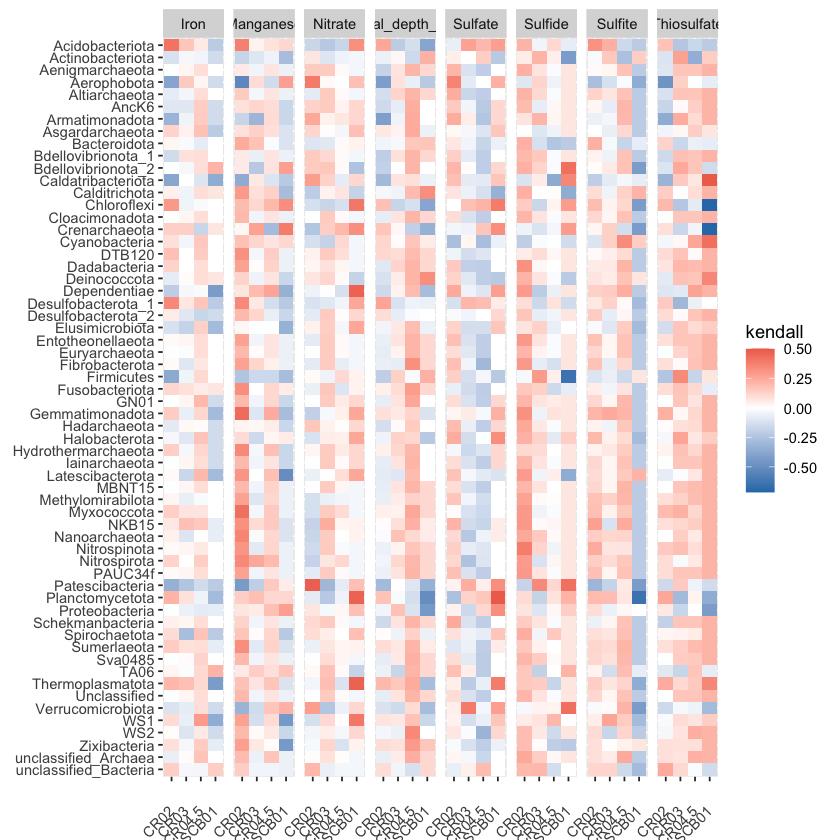

In [365]:
#Make plot, organizing taxa in alphabetical order
p <- ggplot(aes(x=Type, y=factor(Taxa, 
                                 levels = rev(levels(factor(Taxa)))), fill=Correlation), data=df)
p <- p + geom_tile() + scale_fill_gradient2(low="#2C7BB6", mid="white", high="#D7191C") 
p<-p+theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.5))
p<-p+geom_text(aes(label=Significance), color="black", size=3)+labs(y=NULL, x=NULL, fill=method)
p<-p+facet_grid(. ~ Env, drop=TRUE,scale="free",space="free_x")#),labeller=Env_labeller)
#pdf(paste("plots/Correlation_low_ASVs_",adjustment_label[adjustment],".pdf",sep=""),height=8,width=22)
print(p)

#### Creating correlating matrices among environmental variables for each core

In [397]:
#Filter metatable by core
meta_table_mc01 <- filter(sample_info_tab, Core == "MC01")
meta_table_gc02 <- filter(sample_info_tab, Core == "GC02")
meta_table_gc04 <- filter(sample_info_tab, Core == "GC04")
meta_table_gc06 <- filter(sample_info_tab, Core == "GC06")


In [398]:
#Remove absent environmental variables from cores SCB01 and GC06
sel_env_mc01<-c("Real_depth_cm","Iron","Manganese","Nitrate","Sulfate","Sulfide","Sulfite","Thiosulfate")
sel_env_gc06<-c("Real_depth_cm","Iron","Manganese","Nitrate","Sulfate","Sulfide","Sulfite","Thiosulfate")

#keep only relevant variables
meta_table_mc_01_filtered<-meta_table_mc01[,sel_env_mc01]
meta_table_gc_02_filtered<-meta_table_gc02[,sel_env]
meta_table_gc_04_filtered<-meta_table_gc04[,sel_env]
meta_table_gc_06_filtered<-meta_table_gc06[,sel_env_gc06]

In [399]:
#Remove outliers
#meta_table_mc_01_filtered_2 <- subset(meta_table_mc_01_filtered, Real_depth_cm %nin% c("151", "91", "146"))
#meta_table_gc_02_filtered_2 <- subset(meta_table_gc_02_filtered, Real_depth_cm %nin% c())
meta_table_gc_04_filtered_2 <- subset(meta_table_gc_04_filtered, Real_depth_cm %nin% c("26", "21"))
meta_table_gc_06_filtered_2 <- subset(meta_table_gc_06_filtered, Real_depth_cm %nin% c("151", "91", "146"))

In [400]:
#Function to flatten correlation matrix
flattenCorrMatrix <- function(cormat, pmat) {
  ut <- upper.tri(cormat)
  data.frame(
    row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut],
    p = pmat[ut]
  )
}

In [407]:
#Create correlation matrices for each core
res_mc_01 <- rcorr(as.matrix(meta_table_mc_01_filtered), type = "pearson")
res_gc_02 <- rcorr(as.matrix(meta_table_gc_02_filtered), type = "pearson")
res_gc_04 <- rcorr(as.matrix(meta_table_gc_04_filtered_2), type = "pearson")
res_gc_06 <- rcorr(as.matrix(meta_table_gc_06_filtered_2), type = "pearson")

In [408]:
#Flatten corr matrix for MC 01
flat_corr_mc_01 <- flattenCorrMatrix(res_mc_01$r, res_mc_01$P)
#Sort by row name
df_corr_mc_01 <- with(flat_corr_mc_01,  flat_corr_mc_01[order(row) , ])
#Round numeric columns to 3 digits
df_corr_mc_01 <- df_corr_mc_01 %>% 
  mutate(across(where(is.numeric), round, digits=3))
#See dataframe
head(df_corr_mc_01)

,row,column,cor,p
,<chr>,<chr>,<dbl>,<dbl>
3,Iron,Manganese,0.153,0.717
5,Iron,Nitrate,-0.739,0.036
8,Iron,Sulfate,-0.465,0.246
12,Iron,Sulfide,0.260,0.573
17,Iron,Sulfite,0.088,0.852
23,Iron,Thiosulfate,-0.607,0.148


Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphic

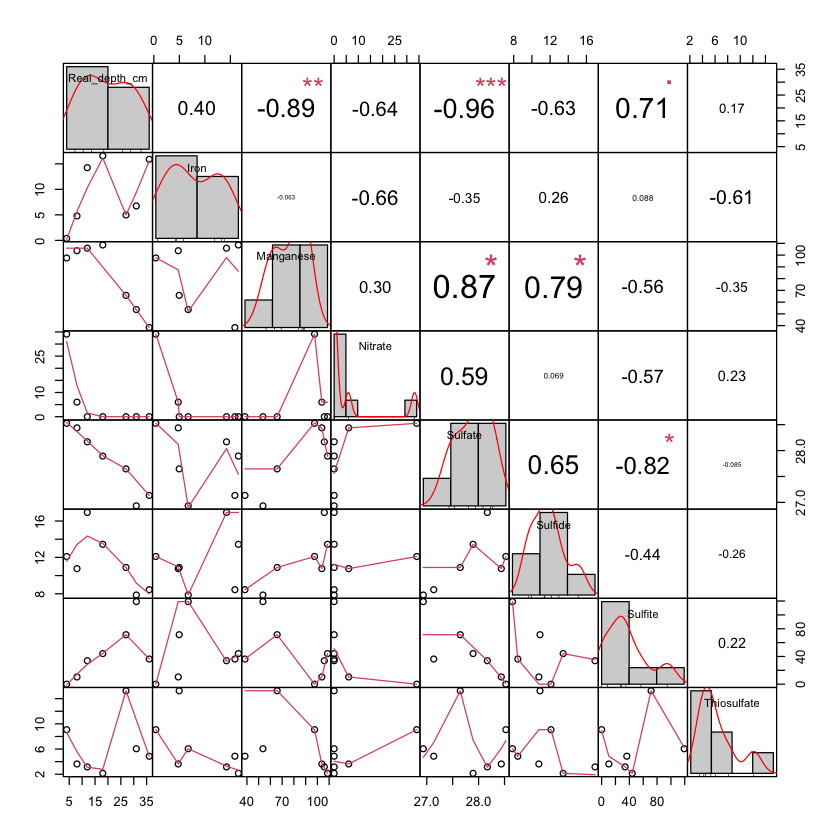

In [409]:
#Make chart
chart.Correlation(meta_table_mc_01_filtered_1)


Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphic

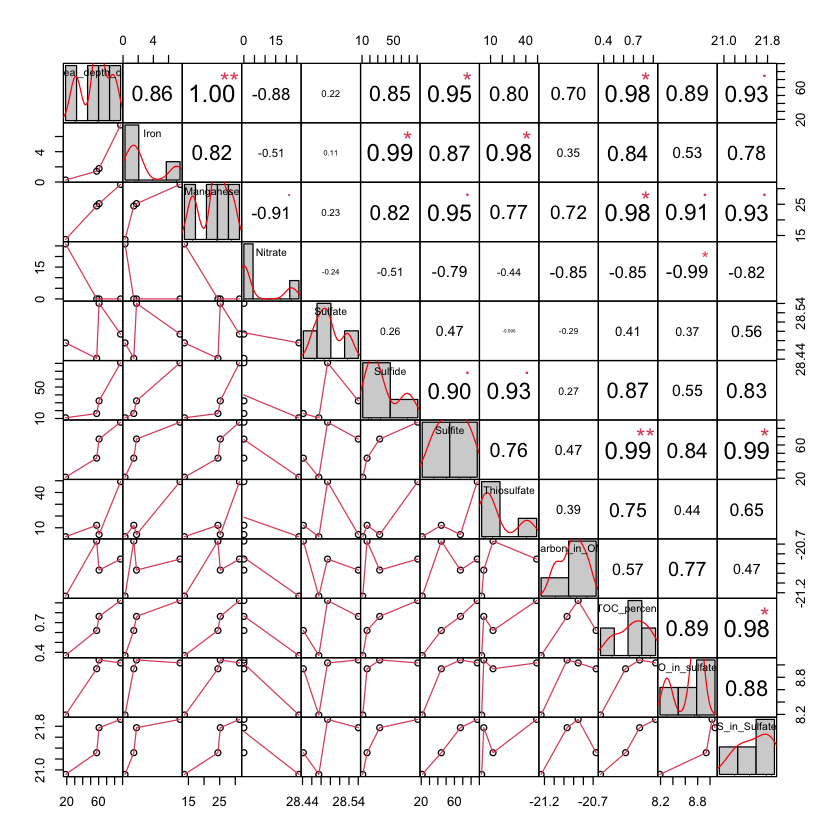

In [404]:
#Flatten corr matrix for GC 02
flat_corr_gc_02 <- flattenCorrMatrix(res_gc_02$r, res_gc_02$P)
#Sort by row name
df_corr_gc_02 <- with(flat_corr_gc_02,  flat_corr_gc_02[order(row) , ])
#Round numeric columns to 3 digits
df_corr_gc_02 <- df_corr_gc_02 %>% 
  mutate(across(where(is.numeric), round, digits=3))
#Build correlation plot
chart.Correlation(meta_table_gc_02_filtered_1)

Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphic

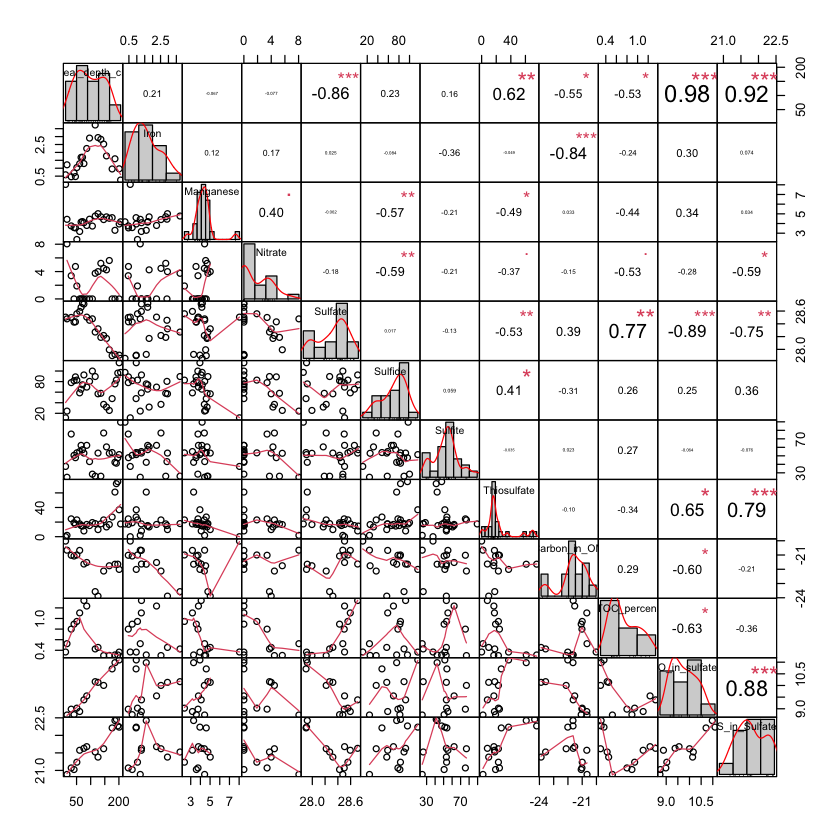

In [405]:
#Flatten corr matrix for GC 04
flat_corr_gc_04 <- flattenCorrMatrix(res_gc_04$r, res_gc_04$P)
#Sort by row name
df_corr_gc_04 <- with(flat_corr_gc_04,  flat_corr_gc_04[order(row) , ])
#Round numeric columns to 3 digits
df_corr_gc_04 <- df_corr_gc_04 %>% 
  mutate(across(where(is.numeric), round, digits=3))
#Build correlation plot
chart.Correlation(meta_table_gc_04_filtered_2)

Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphical parameter"
Warning message in par(usr):
"argument 1 does not name a graphic

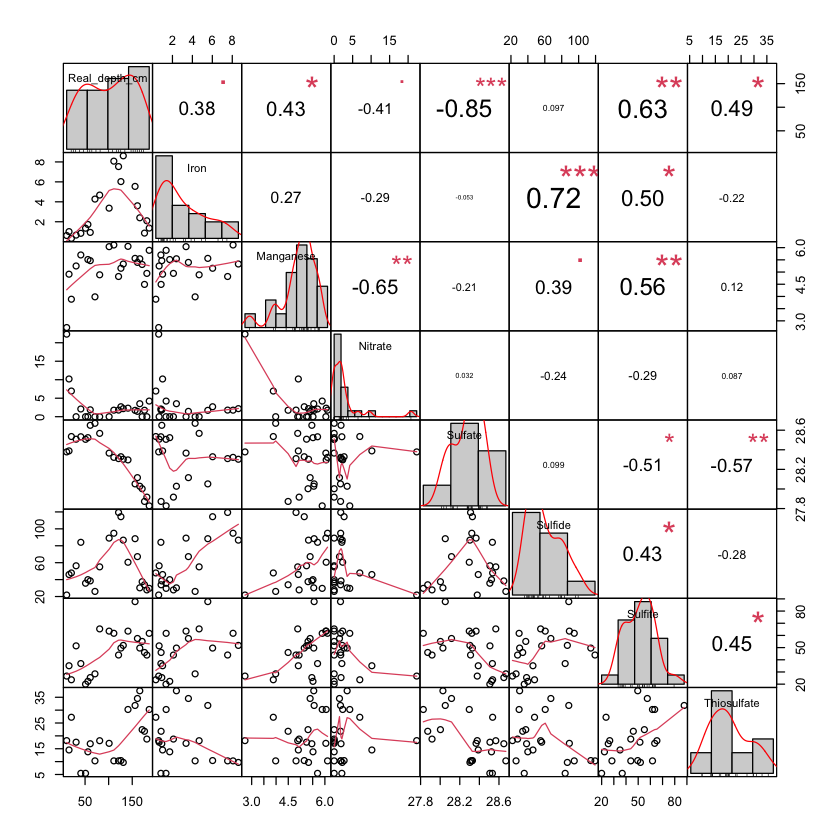

In [406]:
#Flatten corr matrix for GC 06
flat_corr_gc_06 <- flattenCorrMatrix(res_gc_06$r, res_gc_06$P)
#Sort by row name
df_corr_gc_06 <- with(flat_corr_gc_06,  flat_corr_gc_06[order(row) , ])
#Round numeric columns to 3 digits
df_corr_gc_06 <- df_corr_gc_06 %>% 
  mutate(across(where(is.numeric), round, digits=3))
#Build correlation plot
chart.Correlation(meta_table_gc_06_filtered_2)